In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.4 MB/s eta 0:00:00


In [3]:
from transformers import RobertaTokenizer, RobertaModel
import torch
from torch.utils.data import Dataset, DataLoader
from torch import cuda
import torch.optim as optim
import pickle
device = 'cuda' if cuda.is_available() else 'cpu'
import numpy as np
from sklearn import metrics
from tqdm import tqdm
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

MAX_LEN = 64
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32

EPOCHS = 10
LEARNING_RATE = 1e-5

In [3]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained('roberta-base')
        self.l2 = torch.nn.Dropout(0.7)
        self.l3 = torch.nn.Linear(768, 24)

    def forward(self, ids, mask):
        _, output_1= self.l1(ids, attention_mask = mask, return_dict=False)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768

In [4]:
def loss_fn(outputs, targets):
    return torch.nn.CrossEntropyLoss()(outputs, targets)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

training_loss = []
validation_loss = []

NameError: ignored

In [18]:
label_dict ={
    'HEALTHCARE': 0, 'FINANCE': 1, 'HR': 2, 'ADVOCATE': 3, 'APPAREL': 4,
    'ACCOUNTANT': 5, 'CHEF': 6, 'CONSULTANT': 7, 'INFORMATION-TECHNOLOGY': 8, 'FITNESS': 9,
    'BUSINESS-DEVELOPMENT': 10, 'SALES': 11, 'CONSTRUCTION': 12, 'BANKING': 13, 'ENGINEERING': 14,
    'AVIATION': 15, 'PUBLIC-RELATIONS': 16, 'DIGITAL-MEDIA': 17, 'DESIGNER': 18, 'TEACHER': 19,
    'ARTS': 20, 'AGRICULTURE': 21, 'AUTOMOBILE': 22, 'BPO': 23
}

with open('train_new.pickle','rb') as f1:
  train = pickle.load(f1)
with open('valid_new.pickle','rb') as f2:
  valid = pickle.load(f2)
with open('test_new.pickle','rb') as f3:
  test = pickle.load(f3)

train_categories = [label_dict[cat] for cat in train[1]]
train[1] = train_categories

valid_categories = [label_dict[cat] for cat in valid[1]]
valid[1] = valid_categories

test_categories = [label_dict[cat] for cat in test[1]]
test[1] = test_categories

print(len(train[0]))
print(len(train[1]))


54923
54923


In [6]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.jobline = dataframe[0]
        self.category = dataframe[1]
        self.max_len = max_len

    def __len__(self):
        return len(self.jobline)

    def __getitem__(self, index):
        pre_text = self.jobline[index]

        inputs = self.tokenizer(pre_text, padding="max_length", truncation=True, max_length=self.max_len)
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        # token_type_ids = inputs["token_type_ids"]
        targets = torch.zeros(24)
        targets[self.category[index]] = 1

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            # 'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': targets
        }

training_set = CustomDataset(train, tokenizer, MAX_LEN)

print(training_set[25])
print(type(training_set[25]['targets']))

{'ids': tensor([    0,   246,   107,     8,   361,   377,  1437,  1437,     9,   676,
           11,     5,   709,     6,   323,     8, 25387,     9,  3748,     8,
         1437,  6410,  2975,     8,    11,     5,  5574,     9,   701,  2375,
          923,  4917,    29,  1437, 30148,     8,  2226,  3748,   805,  3270,
           11,  1437,  1437,  1437,  1437, 31491,   479, 13548,   155,     4,
          245,     6,  1437,   634,     5,  8326,     8,  1437,   230, 10431,
         1437, 12901,    73,     2]), 'mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'targets': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])}
<class 'torch.Tensor'>


In [7]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

# valid_params = {'batch_size': VALID_BATCH_SIZE,
#                 'shuffle': False,
#                 'num_workers': 0
#                 }

# test_params = {'batch_size': 1,
#                 'shuffle': False,
#                 'num_workers': 0
#                 }

training_loader = DataLoader(training_set, **train_params)
# testing_loader = DataLoader(testing_set, **test_params)
# validation_loader = DataLoader(validation_set, **valid_params)

In [8]:
def train_model(epoch):
    total_loss = 0.0
    loss_count = 0
    model.train()
    for _,data in enumerate(tqdm(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        # token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device)

        outputs = model(ids, mask)
        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        total_loss += loss.item()
        loss_count += 1

        if _%5000==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')


        loss.backward()
        optimizer.step()

    total_loss /= loss_count
    training_loss.append(total_loss)

In [9]:
def validation():
    model.eval()
    predict_labels=[]
    valid_labels = []
    total_loss = 0.0
    loss_count = 0
    with torch.no_grad():
      for job, category in zip(valid[0],valid[1]):
        if not job:
          continue
        valid_labels.append(category)
        inputs = tokenizer(job, padding="max_length", truncation=True, max_length=MAX_LEN)
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        ids = torch.tensor(ids, dtype=torch.long).to(device)
        mask = torch.tensor(mask, dtype=torch.long).to(device)

        # ids = ids.unsqueeze(0)
        # mask = mask.unsqueeze(0)

        output = model(ids, mask)

        target = torch.zeros(24)
        target[category] = 1
        targets = target.repeat(len(job),1)
        targets = targets.to(device)

        loss = loss_fn(output, targets)
        total_loss += loss.item()
        loss_count += 1
        output = torch.mode(torch.argmax(output, dim=1))[0].cpu().item()
        predict_labels.append(output)

    total_loss /= loss_count
    validation_loss.append(total_loss)
    print(f"predict labels: {predict_labels}")
    print(f"valid labels: {valid_labels}" )
    print(f'validation loss: {total_loss}')

    accuracy = metrics.accuracy_score(valid_labels, predict_labels)
    f1_score_micro = metrics.f1_score(valid_labels, predict_labels, average='micro')
    f1_score_macro = metrics.f1_score(valid_labels, predict_labels, average='macro')
    print(f"Accuracy Score = {accuracy}")
    print(f"F1 Score (Micro) = {f1_score_micro}")
    print(f"F1 Score (Macro) = {f1_score_macro}")


    #     for _, data in enumerate(validation_loader, 0):
    #         ids = data['ids'].to(device, dtype = torch.long)
    #         mask = data['mask'].to(device, dtype = torch.long)
    #         # token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
    #         targets = data['targets'].to(device)
    #         outputs = model(ids, mask)

    #         loss = loss_fn(outputs, targets)
    #         total_loss += loss.item()
    #         loss_count += 1

    #         fin_targets.extend(targets.cpu().detach().numpy().tolist())
    #         fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    # total_loss /= loss_count
    # validation_loss.append(total_loss)

In [12]:
for epoch in range(EPOCHS):

    train_model(epoch)
    validation()

  0%|          | 1/1717 [00:00<05:19,  5.37it/s]

Epoch: 0, Loss:  2.5080513954162598


100%|██████████| 1717/1717 [09:50<00:00,  2.91it/s]


predict labels: [10, 0, 5, 4, 8, 19, 0, 8, 19, 12, 14, 0, 13, 6, 14, 10, 18, 8, 8, 0, 14, 15, 10, 10, 19, 5, 12, 3, 4, 19, 5, 8, 9, 8, 12, 17, 0, 13, 18, 12, 8, 19, 8, 18, 12, 17, 15, 15, 6, 19, 1, 10, 5, 5, 8, 12, 10, 16, 2, 13, 13, 8, 16, 2, 8, 8, 14, 7, 13, 17, 8, 3, 4, 1, 8, 19, 12, 4, 18, 16, 19, 17, 10, 0, 10, 5, 6, 12, 18, 13, 2, 19, 15, 2, 2, 15, 8, 12, 8, 17, 14, 0, 3, 2, 12, 19, 12, 0, 6, 19, 4, 10, 5, 0, 19, 0, 5, 8, 13, 17, 12, 6, 5, 15, 13, 4, 12, 12, 14, 8, 12, 10, 8, 5, 12, 16, 5, 3, 2, 17, 18, 5, 19, 5, 12, 14, 5, 6, 0, 13, 19, 12, 11, 9, 5, 12, 8, 5, 8, 8, 2, 16, 12, 10, 8, 19, 19, 6, 14, 18, 4, 13, 17, 2, 0, 10, 15, 2, 1, 8, 8, 8, 14, 10, 8, 5, 1, 5, 8, 8, 11, 10, 18, 5, 8, 10, 8, 12, 16, 8, 9, 5, 9, 1, 8, 4, 8, 5, 13, 14, 1, 0, 6, 5, 12, 9, 15, 16, 8, 0, 6, 15, 11, 5, 12, 18, 12, 1, 14, 16, 5, 18, 13, 16, 8]
valid labels: [10, 7, 1, 20, 8, 19, 0, 20, 19, 15, 14, 10, 13, 18, 18, 2, 17, 7, 7, 9, 14, 15, 10, 10, 20, 1, 21, 8, 4, 3, 5, 8, 9, 8, 14, 19, 20, 10, 4, 17, 8, 

  0%|          | 1/1717 [00:00<04:15,  6.71it/s]

Epoch: 1, Loss:  2.435206413269043


100%|██████████| 1717/1717 [09:50<00:00,  2.91it/s]


predict labels: [10, 0, 5, 4, 8, 19, 0, 8, 19, 12, 14, 0, 13, 6, 14, 10, 18, 8, 8, 0, 14, 15, 10, 10, 19, 5, 21, 3, 4, 19, 5, 8, 9, 8, 12, 17, 0, 13, 18, 12, 8, 19, 8, 18, 12, 17, 15, 15, 6, 19, 5, 10, 5, 5, 8, 12, 12, 16, 2, 13, 10, 8, 16, 2, 8, 8, 14, 8, 12, 17, 8, 3, 4, 12, 8, 19, 12, 4, 18, 16, 19, 17, 10, 0, 10, 5, 6, 12, 18, 13, 2, 19, 15, 2, 2, 15, 8, 12, 8, 17, 14, 0, 3, 2, 12, 19, 12, 0, 6, 19, 4, 10, 5, 0, 19, 3, 5, 8, 0, 17, 12, 6, 5, 15, 13, 4, 12, 12, 14, 8, 12, 10, 8, 5, 12, 16, 5, 3, 2, 17, 18, 5, 19, 5, 12, 14, 5, 6, 0, 13, 19, 12, 11, 9, 5, 12, 8, 5, 8, 8, 2, 16, 12, 10, 8, 19, 19, 6, 14, 14, 4, 13, 17, 2, 0, 10, 15, 2, 1, 8, 8, 8, 14, 10, 8, 5, 1, 5, 8, 8, 11, 4, 18, 5, 8, 10, 8, 12, 16, 14, 9, 5, 9, 1, 8, 4, 8, 5, 13, 14, 1, 0, 6, 5, 12, 9, 15, 16, 8, 0, 6, 15, 11, 5, 12, 18, 12, 1, 14, 16, 5, 18, 13, 16, 8]
valid labels: [10, 7, 1, 20, 8, 19, 0, 20, 19, 15, 14, 10, 13, 18, 18, 2, 17, 7, 7, 9, 14, 15, 10, 10, 20, 1, 21, 8, 4, 3, 5, 8, 9, 8, 14, 19, 20, 10, 4, 17, 8, 

  0%|          | 1/1717 [00:00<04:24,  6.48it/s]

Epoch: 2, Loss:  2.3679656982421875


100%|██████████| 1717/1717 [09:50<00:00,  2.91it/s]


predict labels: [10, 0, 5, 4, 8, 19, 0, 8, 19, 12, 14, 0, 13, 6, 14, 10, 18, 8, 8, 0, 14, 15, 10, 10, 19, 5, 21, 3, 4, 19, 5, 8, 9, 8, 12, 8, 0, 13, 18, 12, 8, 19, 8, 18, 12, 17, 15, 15, 6, 19, 5, 10, 5, 5, 8, 12, 12, 16, 2, 13, 10, 8, 16, 2, 8, 8, 14, 8, 13, 17, 8, 5, 4, 1, 8, 19, 12, 4, 18, 16, 19, 17, 10, 0, 10, 5, 6, 12, 18, 13, 2, 19, 15, 2, 2, 15, 8, 12, 8, 17, 14, 0, 3, 2, 12, 19, 12, 0, 6, 19, 4, 10, 5, 0, 19, 0, 5, 8, 0, 17, 12, 6, 5, 15, 13, 4, 12, 12, 14, 8, 12, 10, 8, 5, 12, 16, 5, 3, 2, 17, 18, 5, 19, 5, 12, 14, 5, 6, 0, 13, 19, 12, 11, 9, 5, 12, 8, 5, 8, 8, 2, 16, 12, 10, 8, 19, 19, 6, 14, 14, 4, 13, 17, 2, 0, 10, 15, 2, 1, 8, 8, 8, 14, 10, 8, 5, 1, 10, 8, 8, 11, 10, 18, 5, 7, 10, 8, 12, 17, 14, 9, 5, 9, 1, 8, 4, 8, 5, 13, 14, 1, 0, 6, 5, 12, 9, 15, 16, 15, 0, 6, 15, 11, 5, 12, 18, 12, 1, 14, 16, 15, 4, 13, 16, 8]
valid labels: [10, 7, 1, 20, 8, 19, 0, 20, 19, 15, 14, 10, 13, 18, 18, 2, 17, 7, 7, 9, 14, 15, 10, 10, 20, 1, 21, 8, 4, 3, 5, 8, 9, 8, 14, 19, 20, 10, 4, 17, 8,

  0%|          | 1/1717 [00:00<03:55,  7.29it/s]

Epoch: 3, Loss:  2.4489591121673584


100%|██████████| 1717/1717 [09:50<00:00,  2.91it/s]


predict labels: [10, 0, 5, 4, 8, 19, 0, 8, 19, 15, 14, 0, 13, 6, 14, 10, 18, 8, 8, 0, 14, 15, 10, 10, 19, 5, 21, 3, 4, 19, 5, 8, 9, 8, 12, 8, 0, 13, 18, 12, 8, 19, 8, 18, 12, 17, 15, 15, 6, 19, 5, 10, 5, 1, 8, 12, 10, 16, 2, 13, 10, 8, 16, 2, 8, 8, 14, 7, 13, 17, 8, 5, 4, 1, 8, 19, 12, 4, 18, 16, 19, 17, 10, 0, 10, 5, 6, 12, 18, 13, 2, 19, 15, 2, 2, 15, 8, 12, 8, 17, 14, 0, 3, 2, 12, 19, 12, 0, 6, 19, 4, 10, 5, 0, 19, 3, 5, 8, 0, 17, 12, 6, 5, 15, 13, 4, 12, 12, 14, 8, 12, 10, 8, 5, 12, 16, 5, 3, 2, 17, 18, 5, 19, 5, 12, 14, 5, 6, 0, 13, 19, 12, 11, 9, 5, 12, 8, 5, 8, 8, 2, 16, 12, 10, 8, 19, 19, 6, 14, 14, 4, 13, 17, 2, 0, 10, 15, 2, 1, 8, 8, 8, 14, 10, 8, 1, 1, 10, 8, 8, 11, 10, 18, 5, 7, 10, 8, 12, 17, 14, 9, 5, 9, 1, 8, 4, 8, 5, 13, 14, 1, 0, 6, 5, 12, 9, 15, 16, 8, 0, 6, 15, 11, 5, 12, 18, 12, 1, 14, 16, 5, 4, 13, 16, 8]
valid labels: [10, 7, 1, 20, 8, 19, 0, 20, 19, 15, 14, 10, 13, 18, 18, 2, 17, 7, 7, 9, 14, 15, 10, 10, 20, 1, 21, 8, 4, 3, 5, 8, 9, 8, 14, 19, 20, 10, 4, 17, 8, 2

  0%|          | 1/1717 [00:00<03:52,  7.39it/s]

Epoch: 4, Loss:  2.469048500061035


100%|██████████| 1717/1717 [09:50<00:00,  2.91it/s]


predict labels: [10, 0, 5, 4, 8, 19, 0, 8, 19, 15, 14, 0, 13, 6, 14, 10, 18, 8, 12, 0, 14, 15, 10, 10, 19, 5, 21, 11, 4, 19, 5, 15, 9, 8, 12, 8, 0, 13, 18, 12, 8, 19, 8, 18, 12, 17, 15, 15, 6, 19, 5, 10, 5, 1, 8, 12, 10, 16, 2, 13, 10, 8, 16, 2, 8, 8, 14, 8, 12, 17, 8, 5, 4, 1, 8, 19, 12, 4, 18, 16, 19, 17, 10, 0, 10, 5, 6, 12, 18, 13, 2, 19, 15, 2, 2, 15, 8, 12, 8, 17, 14, 0, 3, 2, 12, 19, 12, 0, 6, 19, 4, 10, 5, 0, 19, 3, 5, 8, 0, 17, 12, 6, 5, 15, 13, 4, 12, 12, 14, 17, 12, 10, 14, 5, 12, 16, 5, 3, 2, 17, 18, 5, 19, 5, 12, 14, 5, 6, 0, 13, 19, 12, 11, 9, 5, 12, 8, 5, 8, 8, 2, 16, 12, 10, 8, 19, 19, 6, 14, 14, 4, 13, 17, 2, 0, 10, 15, 2, 1, 8, 8, 8, 14, 10, 8, 1, 5, 10, 8, 8, 11, 10, 18, 5, 7, 0, 8, 12, 17, 14, 9, 5, 9, 1, 8, 4, 8, 5, 13, 14, 1, 0, 6, 5, 12, 9, 15, 16, 15, 0, 6, 15, 11, 5, 12, 18, 12, 1, 14, 16, 5, 4, 13, 16, 8]
valid labels: [10, 7, 1, 20, 8, 19, 0, 20, 19, 15, 14, 10, 13, 18, 18, 2, 17, 7, 7, 9, 14, 15, 10, 10, 20, 1, 21, 8, 4, 3, 5, 8, 9, 8, 14, 19, 20, 10, 4, 17,

  0%|          | 1/1717 [00:00<04:37,  6.19it/s]

Epoch: 5, Loss:  2.3205928802490234


100%|██████████| 1717/1717 [09:50<00:00,  2.91it/s]


predict labels: [10, 0, 5, 4, 8, 19, 0, 8, 19, 15, 14, 0, 13, 6, 14, 10, 18, 8, 8, 0, 14, 15, 10, 10, 19, 5, 21, 11, 4, 19, 5, 15, 15, 8, 12, 8, 0, 13, 18, 12, 8, 19, 21, 18, 12, 17, 15, 15, 6, 19, 5, 10, 5, 1, 8, 12, 10, 16, 2, 13, 10, 8, 16, 2, 8, 8, 14, 7, 13, 17, 8, 1, 4, 1, 8, 19, 12, 4, 18, 16, 19, 17, 10, 0, 10, 5, 6, 12, 18, 13, 2, 19, 15, 2, 2, 15, 8, 12, 8, 17, 14, 0, 3, 2, 12, 19, 12, 0, 6, 19, 4, 10, 5, 0, 19, 3, 5, 8, 0, 17, 12, 6, 5, 15, 13, 4, 12, 12, 14, 8, 12, 10, 14, 5, 12, 16, 5, 3, 2, 17, 18, 5, 19, 5, 12, 14, 5, 6, 0, 13, 19, 12, 11, 9, 5, 12, 8, 5, 8, 8, 2, 16, 12, 12, 8, 19, 19, 6, 14, 14, 4, 13, 17, 2, 0, 10, 15, 2, 1, 8, 8, 8, 14, 10, 8, 1, 5, 5, 8, 8, 11, 10, 18, 5, 7, 0, 8, 12, 17, 14, 9, 5, 9, 1, 8, 4, 8, 5, 13, 14, 1, 0, 6, 5, 12, 9, 15, 16, 15, 0, 6, 15, 11, 5, 12, 18, 12, 1, 14, 16, 5, 4, 13, 16, 8]
valid labels: [10, 7, 1, 20, 8, 19, 0, 20, 19, 15, 14, 10, 13, 18, 18, 2, 17, 7, 7, 9, 14, 15, 10, 10, 20, 1, 21, 8, 4, 3, 5, 8, 9, 8, 14, 19, 20, 10, 4, 17, 

  0%|          | 1/1717 [00:00<03:50,  7.44it/s]

Epoch: 6, Loss:  2.198467493057251


100%|██████████| 1717/1717 [09:50<00:00,  2.91it/s]


predict labels: [10, 0, 5, 4, 8, 19, 0, 8, 19, 15, 14, 0, 13, 6, 14, 10, 18, 8, 12, 0, 14, 15, 10, 10, 19, 5, 21, 11, 4, 19, 5, 15, 15, 5, 12, 3, 0, 13, 18, 12, 8, 19, 21, 18, 12, 17, 15, 15, 6, 19, 13, 10, 5, 1, 8, 12, 10, 16, 2, 13, 10, 8, 16, 2, 8, 8, 14, 7, 13, 17, 8, 3, 4, 1, 8, 19, 12, 4, 18, 16, 19, 17, 10, 0, 10, 5, 6, 12, 18, 13, 2, 19, 15, 2, 2, 15, 8, 12, 8, 17, 14, 0, 3, 2, 12, 19, 12, 0, 6, 19, 4, 10, 5, 0, 19, 3, 5, 8, 0, 17, 12, 6, 5, 15, 13, 4, 12, 12, 14, 17, 12, 10, 14, 5, 12, 16, 5, 3, 2, 17, 18, 5, 19, 5, 12, 14, 5, 6, 0, 13, 19, 12, 11, 9, 5, 12, 11, 5, 8, 8, 2, 16, 12, 12, 8, 19, 19, 6, 14, 14, 4, 13, 17, 2, 0, 10, 15, 2, 1, 8, 8, 8, 14, 10, 8, 1, 5, 5, 8, 8, 11, 4, 18, 5, 7, 0, 8, 12, 17, 14, 9, 5, 9, 5, 8, 12, 8, 5, 13, 14, 1, 0, 6, 5, 12, 9, 15, 16, 15, 0, 6, 15, 11, 5, 12, 18, 12, 1, 14, 16, 5, 4, 13, 16, 8]
valid labels: [10, 7, 1, 20, 8, 19, 0, 20, 19, 15, 14, 10, 13, 18, 18, 2, 17, 7, 7, 9, 14, 15, 10, 10, 20, 1, 21, 8, 4, 3, 5, 8, 9, 8, 14, 19, 20, 10, 4, 

  0%|          | 1/1717 [00:00<03:49,  7.49it/s]

Epoch: 7, Loss:  2.316868782043457


  2%|▏         | 40/1717 [00:13<09:37,  2.91it/s]


KeyboardInterrupt: ignored

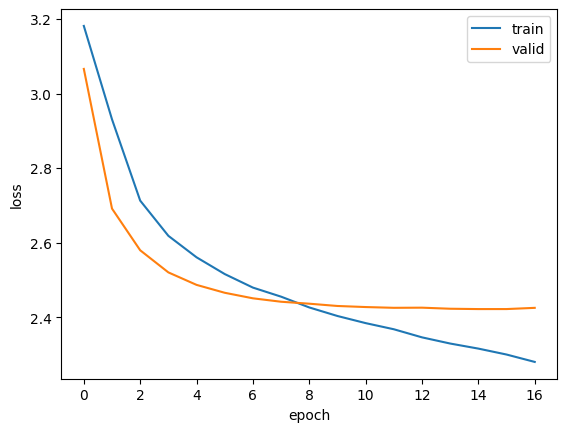

In [14]:
import matplotlib.pyplot as plt

x = range(len(training_loss))
plt.plot(x, training_loss, label="train")
plt.plot(x, validation_loss, label="valid")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()


In [19]:
from collections import Counter

def test_result():
  model.eval()
  predict_labels=[]
  test_labels = []
  total_loss = 0.0
  loss_count = 0
  with torch.no_grad():
    for job, category in zip(test[0],test[1]):
      if not job:
        continue
      test_labels.append(category)
      inputs = tokenizer(job, padding="max_length", truncation=True, max_length=MAX_LEN)
      ids = inputs['input_ids']
      mask = inputs['attention_mask']

      ids = torch.tensor(ids, dtype=torch.long).to(device)
      mask = torch.tensor(mask, dtype=torch.long).to(device)



      output = model(ids, mask)

      output = torch.mode(torch.argmax(output, dim=1))[0].cpu().item()
      predict_labels.append(output)

    print(f"predict labels: {predict_labels}")
    print(f"test labels: {test_labels}" )


    accuracy = metrics.accuracy_score(test_labels, predict_labels)
    f1_score_micro = metrics.f1_score(test_labels, predict_labels, average='micro')
    f1_score_macro = metrics.f1_score(test_labels, predict_labels, average='macro')
    print(f"Accuracy Score = {accuracy}")
    print(f"F1 Score (Micro) = {f1_score_micro}")
    print(f"F1 Score (Macro) = {f1_score_macro}")

test_result()

predict labels: [16, 11, 3, 19, 14, 11, 14, 3, 16, 0, 3, 6, 2, 0, 8, 8, 11, 13, 14, 16, 4, 16, 2, 5, 2, 12, 9, 5, 15, 18, 18, 11, 2, 8, 13, 13, 13, 12, 8, 11, 15, 5, 3, 6, 9, 16, 5, 19, 11, 12, 18, 18, 8, 3, 0, 19, 8, 14, 18, 10, 13, 8, 3, 16, 0, 6, 8, 0, 11, 8, 11, 2, 12, 14, 19, 3, 11, 15, 3, 10, 8, 16, 11, 8, 1, 21, 14, 4, 14, 16, 3, 5, 8, 10, 5, 0, 9, 10, 19, 6, 5, 15, 1, 10, 12, 3, 2, 0, 8, 8, 1, 2, 19, 13, 10, 13, 9, 14, 17, 6, 5, 9, 15, 14, 10, 8, 0, 8, 0, 8, 2, 15, 19, 5, 10, 10, 5, 2, 12, 0, 19, 12, 2, 3, 15, 16, 15, 15, 16, 14, 0, 8, 6, 3, 19, 8, 10, 2, 11, 8, 18, 8, 19, 13, 18, 16, 19, 15, 3, 2, 6, 18, 2, 13, 12, 3, 5, 11, 8, 2, 16, 0, 2, 19, 3, 8, 10, 8, 8, 15, 8, 18, 8, 8, 15, 19, 10, 13, 19, 14, 6, 8, 12, 4, 12, 19, 4, 6, 8, 18, 2, 5, 16, 12, 16, 12, 5, 18, 2, 11, 5, 19, 15, 15, 4, 12, 17, 12, 6, 0, 12, 9, 3, 9]
test labels: [16, 10, 8, 19, 14, 11, 15, 3, 16, 0, 3, 11, 2, 3, 8, 8, 9, 12, 15, 16, 4, 20, 2, 1, 13, 12, 9, 7, 15, 18, 18, 4, 2, 14, 10, 13, 7, 11, 15, 4, 15, 1,